In [3]:
import pandas as pd
df=pd.read_csv('retail.csv')

In [15]:
df.head()

,return_id,order_id,customer_id,return_date,product_id,return_reason,refund_amount_ngn,refund_method,processing_time_days,return_status,restocking_fee_ngn,is_returnted
0,RET0000000,ORD7712767,CUST726777,2024-01-19,PRD87085,late_delivery,124407.43,bank_transfer,7,approved,0.0,0
1,RET0000001,ORD6474212,CUST447076,2024-03-26,PRD84276,changed_mind,195071.65,bank_transfer,10,approved,0.0,0
2,RET0000002,ORD4097385,CUST865931,2024-09-12,PRD14165,defective_product,169538.24,original_payment,8,approved,0.0,0
3,RET0000003,ORD4649345,CUST660548,2024-04-30,PRD22016,changed_mind,68639.06,bank_transfer,12,approved,0.0,0
4,RET0000004,ORD6580141,CUST697693,2024-04-22,PRD29872,damaged_product,141516.76,original_payment,7,approved,0.0,0


In [5]:
df['is_returnted']=df['return_status'].apply(lambda x:1 if x.lower()=='returned' else 0)

In [6]:
df.drop_duplicates(inplace=True)
df=df.dropna(subset=[
    'return_reason',
    'refund_amount_ngn',
    'processing_time_days'
])

In [7]:
df['return_date']=pd.to_datetime(df['return_date'])

In [8]:
df.to_csv('ecommerce_clean.csv',index=False)

In [9]:
df_sample=df.sample(5000,random_state=42)
df_sample.to_csv('sample.csv',index=False)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df=pd.read_csv('ecommerce_clean.csv')


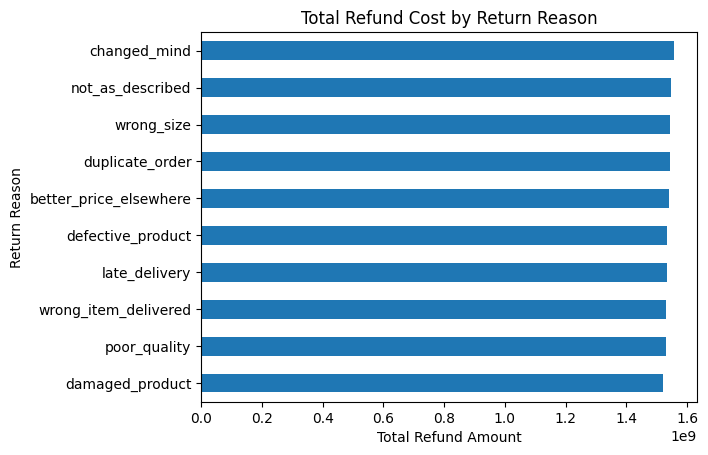

In [2]:
df.groupby('return_reason')['refund_amount_ngn']\
    .sum()\
    .sort_values()\
    .plot(kind='barh')
plt.title('Total Refund Cost by Return Reason')
plt.xlabel('Total Refund Amount')
plt.ylabel('Return Reason')
plt.show()

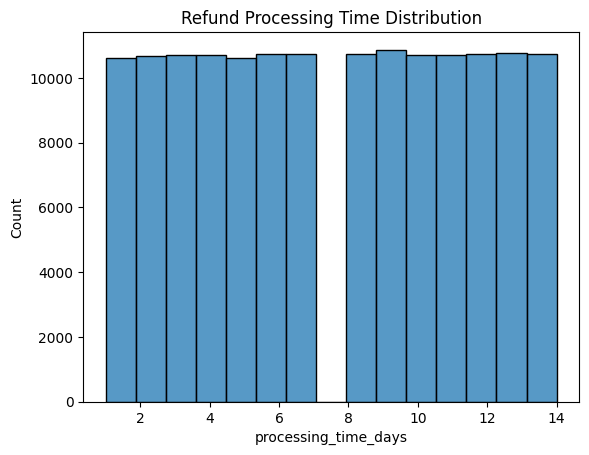

In [3]:
sns.histplot(df['processing_time_days'],bins=15)
plt.title('Refund Processing Time Distribution')
plt.show()

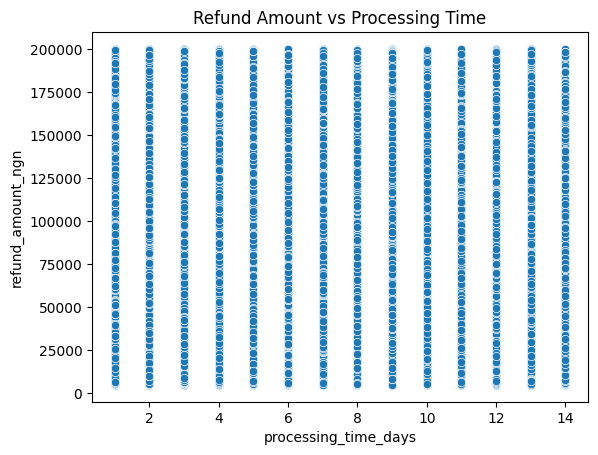

In [4]:
sns.scatterplot(
    x='processing_time_days',
    y='refund_amount_ngn',
    data=df
)
plt.title('Refund Amount vs Processing Time')
plt.show()


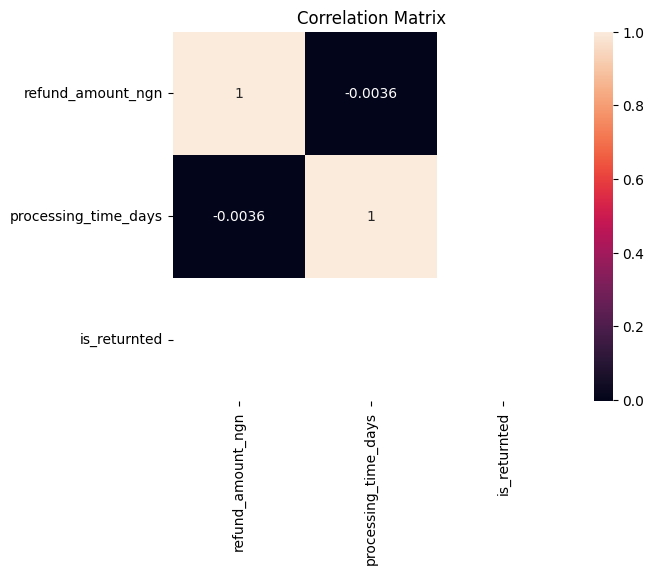

In [5]:
sns.heatmap(
    df[['refund_amount_ngn','processing_time_days','is_returnted']].corr(),annot=True)
plt.title('Correlation Matrix')
plt.show()

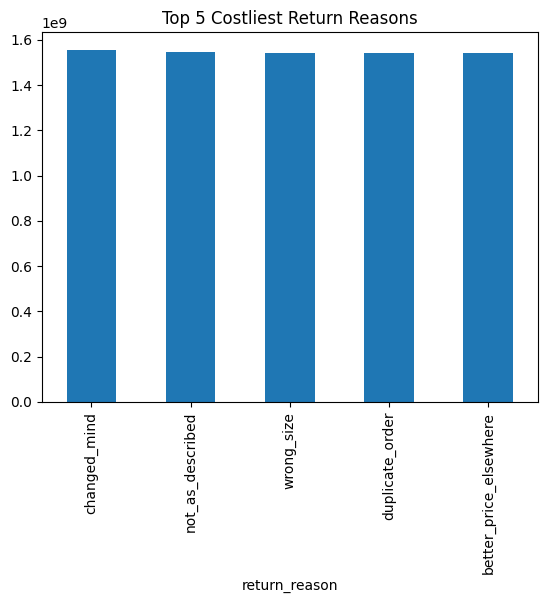

In [6]:
df.groupby('return_reason')['refund_amount_ngn']\
.sum().nlargest(5).plot(kind='bar')
plt.title('Top 5 Costliest Return Reasons')
plt.show()

ML MODEL - RETURN APPROVAL PREDICTION

In [13]:
df['high_cost_return']=(df['refund_amount_ngn']>df['refund_amount_ngn'].median()).astype(int)
model_df=df[[
    'return_reason',
    'refund_method',
    'processing_time_days',
    'high_cost_return']]

In [14]:
model_df=pd.get_dummies(model_df,drop_first=True)

In [15]:
from sklearn.model_selection import train_test_split
X=model_df.drop('high_cost_return',axis=1)
y=model_df['high_cost_return']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred=model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12637  9797]
 [12672  9894]]
              precision    recall  f1-score   support

           0       0.50      0.56      0.53     22434
           1       0.50      0.44      0.47     22566

    accuracy                           0.50     45000
   macro avg       0.50      0.50      0.50     45000
weighted avg       0.50      0.50      0.50     45000



In [18]:
model=LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

<Axes: title={'center': 'Features Impact on High-Cost return'}>

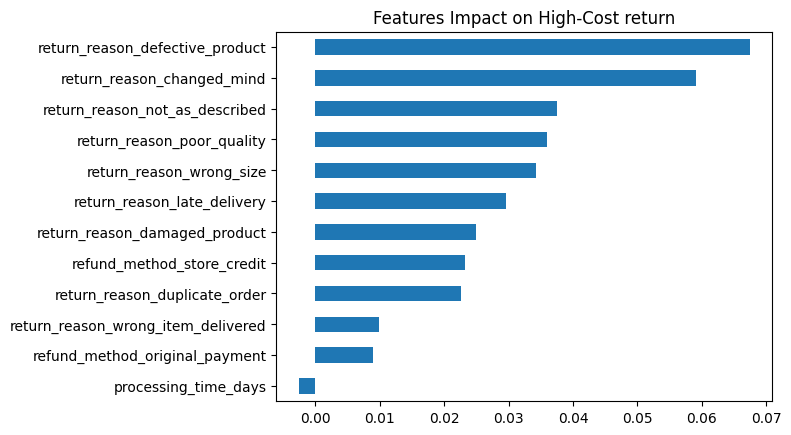

In [19]:
importance=pd.Series(model.coef_[0],index=X.columns).sort_values()
importance.plot(kind='barh',title='Features Impact on High-Cost return')